In [1]:
import faiss as fs
import numpy as np
import fastText as ft
from numpy import genfromtxt
import pandas as pd
import re
import csv
import itertools
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score
from sklearn import svm
from scipy import sparse
from sklearn import preprocessing
from collections import defaultdict, Counter

import codecs
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
color = sns.color_palette()
import tensorflow as tf
import unicodedata
%matplotlib inline
np.random.seed(1234)

/opt/python/dev/Anaconda2-5.0.1/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [106]:
#iconv -t ASCII//IGNORE -c training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat -o training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii

BASE_DIR='/temp0/dev/anjani/models/fasttext/'
#ft_w2v_model ='/temp0/dev/anjani/models/fasttext/training_set_tec_w2v.bin'
ft_w2v_model ='/temp0/dev/anjani/models/fasttext/training_set_tec_trs05301_ascii_w2v.bin'
subcat_test_file = '/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii_20181214.txt'
subcat_test_file_to_vectorize = '/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii_20181214_to_vectorize.txt'

#subcat_file1 = '/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat1'

subcat_train_file = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii_20181214.txt'
subcat_train_file_to_vectorize = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii_20181214_to_vectorize.txt'

#subcat_train_file1 = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat1'

subcat_name_file = '/temp0/dev/anjani/data/fasttext/tec_subcat_code_name.dat'

category_dim = '/temp0/dev/anjani/data/fasttext/tec_dim_category.dat'



In [107]:
nrows = 60000
df_train = pd.read_csv(subcat_train_file, sep="__LABEL__",names=['desc', 'subcat'],encoding ='utf8')
df_test = pd.read_csv(subcat_test_file, sep="__LABEL__",names=['desc', 'subcat'],encoding ='utf8',  nrows=nrows)

/opt/python/dev/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/opt/python/dev/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [108]:
#df_subcatname = pd.read_csv(subcat_name_file, sep="|",names=['code', 'name'],encoding ='utf8')
df_cat_dim = pd.read_csv(category_dim, sep="|",names=['code', 'subcat_name', 'cat_code','cat_name', 'catgrp_code', 'catgrp_name'],encoding ='utf8')

In [109]:
cat_ = zip(df_cat_dim.code,df_cat_dim.cat_code)
cat_code = dict((x, y) for x, y in cat_)

In [110]:
df_test['cat_code'] = df_test['subcat'].apply(lambda x: cat_code[x])
df_train['cat_code'] = df_train['subcat'].apply(lambda x: cat_code[x])

In [105]:
#df_train

In [111]:
le = preprocessing.LabelEncoder()
le.fit(df_train.subcat)
train_full_y = le.transform(df_train.subcat)
test_y = le.transform(df_test.subcat)

In [8]:
le2 = preprocessing.LabelEncoder()
le2.fit(df_train.cat_code)
train_full_y2 = le2.transform(df_train.cat_code)
test_y2 = le2.transform(df_test.cat_code)

In [261]:
#df_train.cat_code

In [112]:
ft_model = ft.load_model(ft_w2v_model)

In [113]:
def get_column_w2v(nrows,input_list, size):
    column_matx = np.zeros((nrows ,100*size))
    #f = open(input_file,'r')
    list2d = []
    word_cnt=0
    for idx, text in enumerate(input_list):
        if not text:
            text='UNK'
        
        for word in text.split():
            if word_cnt <= size -1:
                try:
                    
                    list2d.append(ft_model.get_sentence_vector(word))
                    word_cnt=word_cnt+1
                except: pass

        column_matx[idx,:100*word_cnt] = np.array(list(itertools.chain(*list2d))).astype('float32')  
        word_cnt=0
        list2d=[]
    return column_matx

In [11]:
#input_dim = ft_model.get_dimension()
input_dim = 3000
train_cnt = len(df_train.index)
train_tensor = np.zeros((train_cnt,input_dim))

test_cnt = nrows
test_tensor = np.zeros((test_cnt,input_dim))


In [114]:
input_dim = 3000

In [325]:
## Populate train tensor from word enbedding model
#subcat_train_file = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat_ascii'

i=0
with codecs.open(subcat_train_file,'rb',encoding='utf8') as f:
    for line in f.readlines():
        temp_inp = line.split("__LABEL__")
        if len(temp_inp) != 2:
            print i,temp_inp
        inp = temp_inp[0]
        train_tensor[i] = ft_model.get_sentence_vector(inp)
        i=i+1

In [115]:
with codecs.open(subcat_train_file_to_vectorize,'rb',encoding='utf-8') as f:
    input_list = f.readlines()
    train_tensor =  get_column_w2v(len(input_list),input_list,30)

In [326]:
## Populate test tensor from word enbedding model


i=0
with codecs.open(subcat_test_file,'rb',encoding='utf-8') as f:
    for line in f.readlines():
        if i < nrows:
            inp = line.split("__LABEL__")[0]
            test_tensor[i] = ft_model.get_sentence_vector(inp)
            i=i+1

In [116]:
with codecs.open(subcat_test_file_to_vectorize,'rb',encoding='utf-8') as f:
    input_list = f.readlines()
    test_tensor =  get_column_w2v(nrows,input_list[:nrows],30)

In [117]:
print train_tensor.shape
print test_tensor.shape

(1319955, 3000)
(60000, 3000)


In [118]:
VALIDATION_SPLIT = 0.1
TRAIN_SIZE = train_tensor.shape[0]
TEST_SIZE = test_tensor.shape[0]

perm = np.random.permutation(TRAIN_SIZE)
idx_train = perm[:int(TRAIN_SIZE*(1-VALIDATION_SPLIT))]
idx_val = perm[int(TRAIN_SIZE*(1-VALIDATION_SPLIT)):]


In [119]:
train_x = train_tensor[idx_train]
val_x = train_tensor[idx_val]

train_y = train_full_y[idx_train]
val_y = train_full_y[idx_val]

#train_y2 = train_full_y2[idx_train]
#val_y2 = train_full_y2[idx_val]

In [120]:
class_size=len(le.classes_)
#class_size2=len(le2.classes_)

In [121]:
print class_size

531


In [122]:
num_dense1 = 2500
dropout1 = 0.2

num_dense2 = 1500
dropout2 = 0.2

num_dense3 = 1000
dropout3 = 0.2

#num_dense4 = 600
#dropout4 = 0.2

#num_dense3 = 500
#dropout3 = 0.5

#STAMP = 'dense_%d_%.2f_%d_%.2f_%d_%.2f'%(num_dense1, dropout1,num_dense2, dropout2,num_dense3, dropout3)
STAMP = 'dense_%d_%.2f_%d_%.2f_%d_%.2f'%(num_dense1, dropout1,num_dense2, dropout2,num_dense3, dropout3)
print STAMP


dense_2500_0.20_1500_0.20_1000_0.20


In [123]:
tf.keras.backend.clear_session()

_input = tf.keras.Input(shape =(input_dim,), name = 'input')

_dense_1 = tf.keras.layers.Dense(num_dense1, activation='relu', name = 'dense_layer_1')(_input)
_dense_1 = tf.keras.layers.Dropout(dropout1)(_dense_1)
_dense_1 = tf.keras.layers.BatchNormalization()(_dense_1)

_dense_2 = tf.keras.layers.Dense(num_dense2, activation='relu', name = 'dense_layer_2')(_dense_1)
_dense_2 = tf.keras.layers.Dropout(dropout2)(_dense_2)
_dense_2 = tf.keras.layers.BatchNormalization()(_dense_2)

_dense_3 = tf.keras.layers.Dense(num_dense3, activation='relu', name = 'dense_layer3')(_dense_2)
_dense_3 = tf.keras.layers.Dropout(dropout3)(_dense_3)
_dense_3 = tf.keras.layers.BatchNormalization()(_dense_3)

#_dense_4 = tf.keras.layers.Dense(num_dense4, activation='relu', name = 'dense_layer4')(_dense_3)
#_dense_4 = tf.keras.layers.Dropout(dropout4)(_dense_4)
#_dense_4 = tf.keras.layers.BatchNormalization()(_dense_4)

_output = tf.keras.layers.Dense(class_size, activation='softmax', name='softmax')(_dense_3)
#_output2 = tf.keras.layers.Dense(class_size2, activation='softmax', name='cat_dense_softmax')(_dense_2)

In [124]:
model = tf.keras.models.Model(inputs=[_input], outputs=[_output])
model.compile(loss='sparse_categorical_crossentropy',
        optimizer='nadam',
        metrics=['acc'])


In [125]:
bst_model_path = BASE_DIR + '/' +STAMP + '.h5'
#model.load_weights(bst_model_path)

In [126]:
early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
ReduceLROnPlateau= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

tbCallBack = tf.keras.callbacks.TensorBoard(log_dir=BASE_DIR, histogram_freq=1, write_graph=True, \
                                            write_images=True,write_grads=True)

In [127]:
hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, \
                 batch_size=512, shuffle=True,verbose=1, callbacks=[early_stopping, model_checkpoint,ReduceLROnPlateau])


Train on 1187959 samples, validate on 131996 samples
Epoch 1/10
1187959/1187959 [==============================] - 391s 329us/step - loss: 1.5346 - acc: 0.6371 - val_loss: 1.0934 - val_acc: 0.7263
Epoch 2/10
1187959/1187959 [==============================] - 354s 298us/step - loss: 1.0130 - acc: 0.7405 - val_loss: 0.9501 - val_acc: 0.7593
Epoch 3/10
1187959/1187959 [==============================] - 336s 283us/step - loss: 0.8299 - acc: 0.7803 - val_loss: 0.8907 - val_acc: 0.7748
Epoch 4/10
1187959/1187959 [==============================] - 335s 282us/step - loss: 0.7080 - acc: 0.8074 - val_loss: 0.8636 - val_acc: 0.7839
Epoch 5/10
1187959/1187959 [==============================] - 334s 281us/step - loss: 0.6151 - acc: 0.8287 - val_loss: 0.8550 - val_acc: 0.7905
Epoch 6/10
1187959/1187959 [==============================] - 335s 282us/step - loss: 0.5445 - acc: 0.8451 - val_loss: 0.8556 - val_acc: 0.7937
Epoch 7/10
1187959/1187959 [==============================] - 337s 284us/step - los

In [ ]:
y_pred_prob = hist.model.predict(test_tensor,batch_size=4096*10, verbose=1)
y_pred = np.argmax(y_pred_prob,axis=1)
f1score= f1_score(test_y,y_pred, average='weighted')
print f1score

In [140]:
early_stopping =tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=False)
ReduceLROnPlateau= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

hist = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=200, \
                 batch_size=512, shuffle=True,verbose=1, callbacks=[early_stopping, model_checkpoint,ReduceLROnPlateau])


Train on 1187959 samples, validate on 131996 samples
Epoch 1/200
1187959/1187959 [==============================] - 344s 289us/step - loss: 0.1361 - acc: 0.9558 - val_loss: 1.0706 - val_acc: 0.8147
Epoch 2/200
1187959/1187959 [==============================] - 344s 289us/step - loss: 0.1315 - acc: 0.9571 - val_loss: 1.0856 - val_acc: 0.8149
Epoch 3/200
1187959/1187959 [==============================] - 344s 290us/step - loss: 0.1277 - acc: 0.9582 - val_loss: 1.0983 - val_acc: 0.8143
Epoch 4/200
1187959/1187959 [==============================] - 344s 289us/step - loss: 0.1234 - acc: 0.9596 - val_loss: 1.1024 - val_acc: 0.8150
Epoch 5/200
1187959/1187959 [==============================] - 344s 289us/step - loss: 0.1198 - acc: 0.9607 - val_loss: 1.1115 - val_acc: 0.8150
Epoch 6/200
1187959/1187959 [==============================] - 344s 290us/step - loss: 0.1168 - acc: 0.9614 - val_loss: 1.1257 - val_acc: 0.8149
Epoch 7/200
1187959/1187959 [==============================] - 343s 289us/ste

In [141]:
y_pred_prob = hist.model.predict(test_tensor,batch_size=4096*10, verbose=1)
y_pred = np.argmax(y_pred_prob,axis=1)
f1score= f1_score(test_y,y_pred, average='weighted')
print f1score

60000/60000 [==============================] - 6s 95us/step
0.7725670908778642


In [142]:
#import tf.keras.backend as K
# for some model with dropout ...
#subcat_models = multi_gpu_model(subcat_models, gpus=4) ## Load the model to 4 GPUs
f = tf.keras.backend.function([hist.model.layers[0].input, tf.keras.backend.learning_phase()],
               [hist.model.layers[-1].output])


In [143]:
def predict_with_uncertainty_batch(f, x, no_classes, n_iter,batch_size):
    result = np.zeros((n_iter,) + (x.shape[0], no_classes) )
    total_iter = x.shape[0]/batch_size + 1
    
    leftover = x.shape[0]%batch_size
    #print total_iter,leftover
    for i in range(n_iter):
        #print i
        #print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        for p in range(total_iter):
            
            if x.shape[0]/batch_size > 0:
                result[i,batch_size*p:(batch_size*p + batch_size),:] = f((x[batch_size*p: (batch_size*p + batch_size)], 1))[0]
            else:
                result[i,batch_size*p:(batch_size*p + leftover),:] = f((x[batch_size*p: (batch_size*p + batch_size)], 1))[0]
        
    prediction = result.mean(axis=0)
    uncertainty = result.std(axis=0)
    return result, prediction ,uncertainty

In [144]:
result, y1_pred_prob ,uncertainty=predict_with_uncertainty_batch\
(f,test_tensor ,no_classes=class_size, n_iter=100,batch_size=4096*10)

In [135]:
y1_pred = np.argmax(y1_pred_prob,axis=1)
y1_pred_pct = np.max(y1_pred_prob,axis=1)
f1score1= f1_score(test_y,y1_pred, average='weighted')
print f1score1

0.7659829811760975


In [29]:
y_pred_prob = hist.model.predict(test_tensor,batch_size=4096*10, verbose=1)
y_pred = np.argmax(y_pred_prob,axis=1)
y_pred_pct = np.max(y_pred_prob,axis=1)
f1score= f1_score(test_y,y_pred, average='weighted')
print f1score

60000/60000 [==============================] - 4s 75us/step
0.7279116010218867


In [145]:
uncertainty_new = np.zeros(uncertainty.shape[0])
for i in range(uncertainty.shape[0]):
    uncertainty_new[i] = uncertainty[i][y_pred[i]]

In [146]:
most_var = np.argsort(-uncertainty_new)
fc=[f1_score(test_y[most_var[i:]],y_pred[most_var[i:]], average='weighted') for i in range(0,nrows,1000)]  #
mean_var=[np.mean(uncertainty_new[i:]) for i in range(0,nrows,1000)]

In [147]:
fc_size = zip([round(float(i)/float(nrows)*100,2) for i  in range(nrows,0,-1000)],fc)
pd_fc_size = pd.DataFrame({"Pct_Rec":[float(i)/float(nrows) for i  in range(nrows,0,-1000)],"Score":fc})

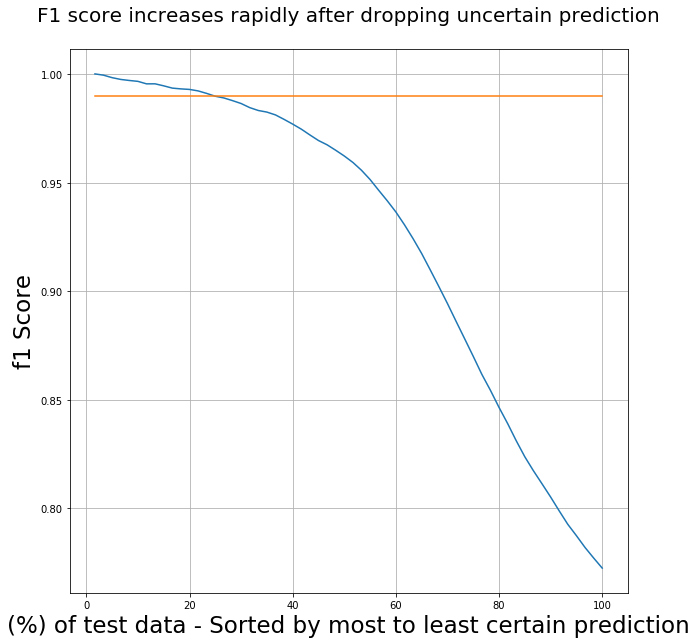

In [148]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel("(%) of test data - Sorted by most to least certain prediction", size=23)
plt.ylabel("f1 Score", size=23)
plt.title("F1 score increases rapidly after dropping uncertain prediction\n", size=20)
plt.plot([round(float(i)/float(nrows)*100,2) for i  in range(nrows,0,-1000)], fc)
plt.plot([round(float(i)/float(nrows)*100,2) for i  in range(nrows,0,-1000)],[0.99 for i  in range(nrows,0,-1000)])


In [161]:
hist.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 3000)              0         
_________________________________________________________________
dense_layer_1 (Dense)        (None, 1000)              3001000   
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1000)              4000      
_________________________________________________________________
dense_layer_2 (Dense)        (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 500)               2000      
__________

In [35]:
df_cat_dim.head()

,code,subcat_name,cat_code,cat_name,catgrp_code,catgrp_name
0,1569410,BTO Bare-Bones Computers,1569401,Total BTO PCs,60477,Computers
1,1569409,BTO Desktop Computers,1569401,Total BTO PCs,60477,Computers
2,1569408,BTO Notebook Computers,1569401,Total BTO PCs,60477,Computers
3,1569407,BTO Servers,1569401,Total BTO PCs,60477,Computers
4,1569406,BTO Terminals,1569401,Total BTO PCs,60477,Computers


In [76]:
subcat_code_name = zip(df_cat_dim.code,df_cat_dim.subcat_name)
subcat_code_name = dict((x, y) for x, y in subcat_code_name)

In [77]:
cat_code_name = zip(df_cat_dim.code,df_cat_dim.cat_name)
cat_code_name = dict((x, y) for x, y in cat_code_name)

In [78]:
df_test['subcat_name'] = df_test['subcat'].apply(lambda x: subcat_code_name[x])
df_test['cat_name'] = df_test['subcat'].apply(lambda x: cat_code_name[x])

In [79]:
df_test['pred_subcat_code'] = le.classes_[y1_pred]
df_test['pred_subcat_name'] = df_test['pred_subcat_code'].apply(lambda x: subcat_code_name[x])
df_test['pred_cat_name'] = df_test['pred_subcat_code'].apply(lambda x: cat_code_name[x])

In [80]:
df_test['point_pred_proba'] = y_pred_pct
df_test['mean_pred_proba'] = y1_pred_pct

In [81]:
df_test['desc1'] = df_test['desc'].apply(lambda x: x.replace(",",""))
df_test['subcat_name'] = df_test['subcat_name'].apply(lambda x: x.replace(",",""))
df_test['cat_name'] = df_test['cat_name'].apply(lambda x: x.replace(",",""))
df_test['pred_subcat_name'] = df_test['pred_subcat_name'].apply(lambda x: x.replace(",",""))
df_test['pred_cat_name'] = df_test['pred_cat_name'].apply(lambda x: x.replace(",",""))

In [82]:
df_test['pred_variance'] = uncertainty_new

In [83]:
df_test.to_csv('/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_pred_with_mean_conf.csv',sep="|",index=False,header=False, columns=['desc1','subcat_name','cat_name','point_pred_proba','mean_pred_proba','pred_subcat_name','pred_cat_name','pred_variance'] )

In [85]:
#input_sen1 = df_train.iloc[10].desc        
input_sen1 = 'HEALTH AND BEAUTY AIDS LIQUID SOAP COLGATEPALMOLIVE COMPANY SOFTSOAP PUMPS 3 PACK 15 OZ 3 PACK 15 OZ'

In [91]:
input_sen=np.array(input_sen1.split())

In [92]:
#exp_tensor = np.zeros((11,3000)) 
exp_list=[]
ln = len(input_sen)
if ln <=30:
    list(input_sen) + (30-ln)*['UNK']
print input_sen
for i in range(50):
    #exp_list.append(" ".join(list(input_sen[np.random.permutation(len(input_sen))])))
    l = list(input_sen[np.sort(np.random.permutation(int(ln))[:3])])
    #print list(set(input_sen) - set(l))
    exp_list.append(" ".join(l))
exp_list.append(input_sen1)
#print  exp_list  
exp_list = list(set(exp_list))
print exp_list
exp_tensor = get_column_w2v(len(exp_list),exp_list,30)
exp_y_pred_prob = hist.model.predict(exp_tensor,batch_size=10, verbose=1)
exp_y_pred = np.argmax(exp_y_pred_prob,axis=1)
exp_y_pred_pct = np.max(exp_y_pred_prob,axis=1)
for ct in list(le.classes_[exp_y_pred]):
    print subcat_code_name[ct]

['HEALTH' 'AND' 'BEAUTY' 'AIDS' 'LIQUID' 'SOAP' 'COLGATEPALMOLIVE'
 'COMPANY' 'SOFTSOAP' 'PUMPS' '3' 'PACK' '15' 'OZ' '3' 'PACK' '15' 'OZ']
['SOAP COMPANY PACK', 'COMPANY PUMPS OZ', 'HEALTH COMPANY OZ', 'AND COMPANY 3', 'LIQUID SOAP 15', 'HEALTH SOAP OZ', 'SOFTSOAP 15 PACK', 'AND BEAUTY COMPANY', 'COLGATEPALMOLIVE SOFTSOAP 3', 'AIDS SOAP COMPANY', 'LIQUID SOAP OZ', 'AIDS SOAP OZ', 'LIQUID COMPANY OZ', 'COLGATEPALMOLIVE SOFTSOAP PACK', 'BEAUTY AIDS 15', '3 OZ PACK', 'BEAUTY AIDS LIQUID', 'COMPANY 3 OZ', 'HEALTH AND BEAUTY AIDS LIQUID SOAP COLGATEPALMOLIVE COMPANY SOFTSOAP PUMPS 3 PACK 15 OZ 3 PACK 15 OZ', 'HEALTH LIQUID COMPANY', 'HEALTH SOAP PUMPS', 'PUMPS PACK OZ', 'AIDS COLGATEPALMOLIVE 3', 'BEAUTY COLGATEPALMOLIVE PACK', 'AND 3 PACK', 'AIDS SOAP 3', 'SOAP 15 15', 'HEALTH 15 15', 'HEALTH SOFTSOAP PUMPS', 'BEAUTY 3 15', 'AND BEAUTY PACK', 'AND PUMPS OZ', 'AIDS PACK OZ', 'HEALTH AIDS OZ', 'BEAUTY PACK 15', 'HEALTH PUMPS OZ', '15 OZ OZ', 'BEAUTY PUMPS 15', 'OZ PACK OZ', 'AND SOAP 3', 'A

In [94]:
f = tf.keras.backend.function([hist.model.layers[0].input, tf.keras.backend.learning_phase()],
               [hist.model.layers[-1].output])
input_sen = 'TELEVISION 70 + TELEVISION SAMSUNG ELECTRONICS CANADSAMSTV SAMSUNG UN78JS8600 78 LED 4K SMART'
#input_sen=np.array(input_sen.split())
input_sen =[input_sen]
print input_sen
exp_tensor = get_column_w2v(1,input_sen,30)
print exp_tensor
exp_y_pred_prob = hist.model.predict(exp_tensor,batch_size=10, verbose=1)
exp_y_pred = np.argmax(exp_y_pred_prob,axis=1)
exp_y_pred_pct = np.max(exp_y_pred_prob,axis=1)
print subcat_code_name[le.classes_[exp_y_pred][0]]
result, y1_pred_prob ,uncertainty=predict_with_uncertainty_batch\
(f,exp_tensor ,no_classes=class_size, n_iter=100,batch_size=100)
y1_pred = np.argmax(y1_pred_prob,axis=1)
y1_pred_pct = np.max(y1_pred_prob,axis=1)
print subcat_code_name[le.classes_[y1_pred][0]],y1_pred_pct

['TELEVISION 70 + TELEVISION SAMSUNG ELECTRONICS CANADSAMSTV SAMSUNG UN78JS8600 78 LED 4K SMART']
[[ 0.01062186 -0.15169235 -0.10375793 ...  0.          0.
   0.        ]]
1/1 [==============================] - 0s 7ms/step
LCD TV
Retail Unknowns [0.95019291]


In [343]:
result, y1_pred_prob ,uncertainty=predict_with_uncertainty_batch\
(f,exp_tensor ,no_classes=class_size, n_iter=100,batch_size=1)

In [344]:
y1_pred = np.argmax(y1_pred_prob,axis=1)
y1_pred_pct = np.max(y1_pred_prob,axis=1)
#f1score1= f1_score(test_y,y1_pred, average='weighted')
#print f1score1

In [331]:
print subcat_code_name[le.classes_[y1_pred][0]]

Retail Unknowns


In [225]:
exp_y_pred

array([300,  70, 106,  40, 108,  28,  40, 266,  28])

In [224]:
subcat_code_name[df_train.iloc[10].subcat]

u'Organizer/Planner Accessories'

In [238]:
set('Notebook Computers') - set('Noteook Computers')

{'b'}

In [96]:
df_test[df_test['point_pred_proba'] ==1.00000]

,desc,subcat,cat_code,subcat_name,cat_name,pred_subcat_code,pred_subcat_name,pred_cat_name,point_pred_proba,mean_pred_proba,desc1,pred_variance
19,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS JU...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999999,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS JU...,1.640140e-04
24,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS CO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999970,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS CO...,9.566266e-05
35,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS EY...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999980,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS EY...,8.216636e-06
74,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HI...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.971942,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HI...,5.654551e-05
90,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AQ...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.991049,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AQ...,5.295179e-03
95,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HA...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999892,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HA...,2.593862e-04
113,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS SO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.986420,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS SO...,2.841267e-02
119,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS RO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999399,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS RO...,1.695513e-01
155,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS VI...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999986,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS VI...,3.781631e-02
175,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AU...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.0,0.999991,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AU...,1.006307e-01


In [97]:
df_test[df_test['subcat_name'] =='Mobile Holders/Stands'] 

,desc,subcat,cat_code,subcat_name,cat_name,pred_subcat_code,pred_subcat_name,pred_cat_name,point_pred_proba,mean_pred_proba,desc1,pred_variance
13,WIRELESS STEELIE CAR KIT,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1588740,Mobile Power,Mobile Power,0.698276,0.532889,WIRELESS STEELIE CAR KIT,0.188884
19,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS JU...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.999999,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS JU...,0.000164
24,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS CO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.999970,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS CO...,0.000096
35,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS EY...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.999980,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS EY...,0.000008
74,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HI...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.971942,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HI...,0.000057
90,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AQ...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.991049,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS AQ...,0.005295
95,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HA...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.999892,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS HA...,0.000259
113,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS SO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.986420,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS SO...,0.028413
119,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS RO...,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557829,Mobile Holders/Stands,Cell Phone Accessories,1.000000,0.999399,WIRELESS PRINT ONDEMAND POPSOCKETS WIRELESS RO...,0.169551
127,WIRELESS IOTTIE EASY ONE TOUC,1557829,60569,Mobile Holders/Stands,Cell Phone Accessories,1557832,Cell Phone Device Protection,Cell Phone Accessories,0.492066,0.526339,WIRELESS IOTTIE EASY ONE TOUC,0.276471


In [99]:
df_test

,desc,subcat,cat_code,subcat_name,cat_name,pred_subcat_code,pred_subcat_name,pred_cat_name,point_pred_proba,mean_pred_proba,desc1,pred_variance
0,DESKTOP PC DESKTOP PC LENOVO REFURBISHED LENOV...,60620,60500,Desktop Computers,Total PCs,60620,Desktop Computers,Total PCs,0.999638,0.997726,DESKTOP PC DESKTOP PC LENOVO REFURBISHED LENOV...,0.014944
1,TO BE DETERMINED NO CATEGORY SYNNEXWCC SUPPLY ...,1519782,1519781,All Other Warranties,Warranties,1577360,Other Networking,Networking Devices,0.629899,0.402802,TO BE DETERMINED NO CATEGORY SYNNEXWCC SUPPLY ...,0.079019
2,HARDWARE SYSTEMS DESKTOPS/SERVERS ORIGIN PC NE...,1569409,1569401,BTO Desktop Computers,Total BTO PCs,1569409,BTO Desktop Computers,Total BTO PCs,0.885136,0.817430,HARDWARE SYSTEMS DESKTOPS/SERVERS ORIGIN PC NE...,0.274598
3,ELECTRONICS BELKIN LTHR NANO,112743,111091,PDPA Cases And Protectors,Portable Digital Player Accessories,1588740,Mobile Power,Mobile Power,0.481018,0.675270,ELECTRONICS BELKIN LTHR NANO,0.250734
4,LENOVO CANADAOPTION A/V JABRA 6599823309 WRLS,60727,60572,PC Headset/PC Microphone,Landline Headset Equipment,36969,Telecom Equip,Communication Devices,0.076012,0.200674,LENOVO CANADAOPTION A/V JABRA 6599823309 WRLS,0.137470
5,SW DATA DOMAIN CAT DD 1 EMC DD SOFTWARE CB,2015765,2015744,Storage Utilities and Management,Storage and Data Protection,2015765,Storage Utilities and Management,Storage and Data Protection,0.759508,0.858777,SW DATA DOMAIN CAT DD 1 EMC DD SOFTWARE CB,0.265608
6,MARCAS ARANDA SOFTWARE ARANDA SOFTWARE ARANDA ...,2015771,2015742,Business Intelligence & Database Systems,Database and Application Development,2015752,Content & Collaboration,Business Applications,0.384133,0.363155,MARCAS ARANDA SOFTWARE ARANDA SOFTWARE ARANDA ...,0.151937
7,SVC NETSCALER CITRIX 1 MONTH GOLD MAINTENANCE ...,2015760,2015746,Virtualization Infrastructure Software,IT Operations and Networking,1519782,All Other Warranties,Warranties,0.420221,0.556599,SVC NETSCALER CITRIX 1 MONTH GOLD MAINTENANCE ...,0.356391
8,LENOVO DCG SERVER OP 480GB SSD SATA 2.5IN ENTR...,1523192,1556059,Solid State Drives,Solid State Drives,1523192,Solid State Drives,Solid State Drives,0.992338,0.995096,LENOVO DCG SERVER OP 480GB SSD SATA 2.5IN ENTR...,0.006037
9,ABBOTT ACTION RSC 10X10X6 200# SW 25/BND,1509099,1508967,Corrugated Boxes,Packing Products,2015771,Business Intelligence & Database Systems,Database and Application Development,0.396728,0.224628,ABBOTT ACTION RSC 10X10X6 200# SW 25/BND,0.199166
